In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import tensorflow as tf

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import tensorflow_probability as tfp

import os
import sys
sys.path.append('..')

RECS_DIR = '../resources/datasets/mass/register'

from sleeprnn.data import utils
from sleeprnn.common import viz
from sleeprnn.nn import augmentations

viz.notebook_full_width()

/home/ntapia/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Channel extracted: EEG C3-CLE
4000


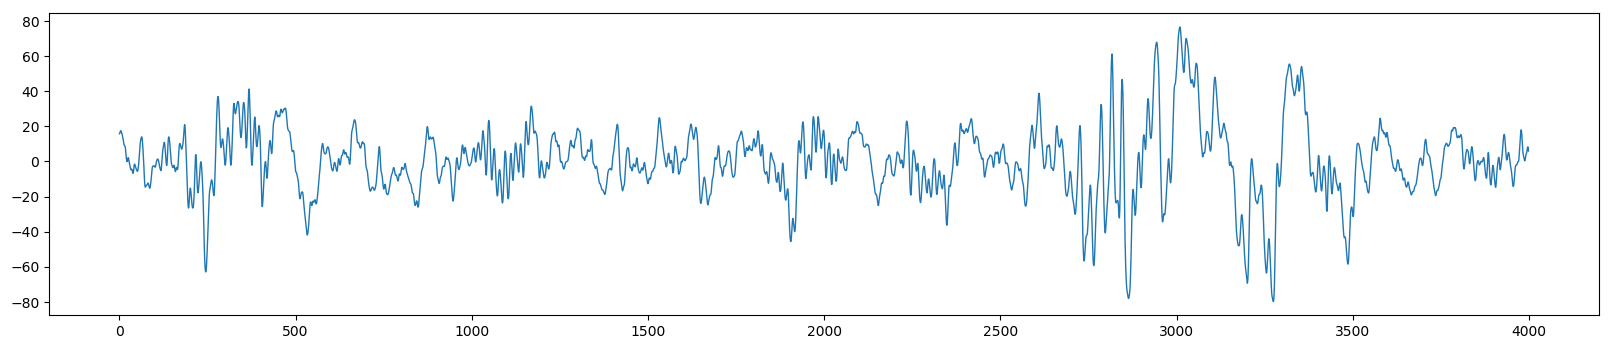

In [23]:
subject_id = 1
fs = 200
segment_size = 20

channel = 'EEG C3-CLE'
path_eeg_file = os.path.join(RECS_DIR, '01-02-%04d PSG.edf' % subject_id)

with pyedflib.EdfReader(path_eeg_file) as file:
    channel_names = file.getSignalLabels()
    channel_to_extract = channel_names.index(channel)
    signal = file.readSignal(channel_to_extract)
    fs_old = file.samplefrequency(channel_to_extract)
    # Check
    print('Channel extracted: %s' % file.getLabel(channel_to_extract))

# Particular fix for mass dataset:
fs_old_round = int(np.round(fs_old))
# Transform the original fs frequency with decimals to rounded version
signal = utils.resample_signal_linear(signal, fs_old=fs_old, fs_new=fs_old_round)
signal = utils.broad_filter(signal, fs_old_round)
signal = utils.resample_signal(signal, fs_old=fs_old_round, fs_new=fs)

input_size = int(segment_size * fs)
print(input_size)

label_dummy = np.zeros(input_size, dtype=np.int32)
label_dummy[1000:1400] = 1

page_idx = 700

start_sample = int(input_size * page_idx)
end_sample = start_sample + input_size
fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=100)
ax.plot(signal[start_sample:end_sample], linewidth=1)
plt.show()

In [8]:
def warp_1d(signal, flow, name='dense_1d_warp'):
    """
    Per-sample warping
    
    Apply a non-linear warp to the signal, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the logits signal back to locations in the source signal. Specifically, the
    pixel value at logits[b, i, c] is images[b, i - flow[b, i], c].

    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by linear
    interpolation of the nearest samples around
    (b, i - flow[b, i]). For locations outside
    of the signal, we use the nearest pixel values at the signal boundary.

    Args:
        signal: 3-D float `Tensor` with shape `[batch, time_len, channels]`.
        flow: A 2-D float `Tensor` with shape `[batch, time_len]`.
        name: A name for the operation (optional).

      Returns:
        A 3-D float `Tensor` with shape`[batch, time_len, channels]`
          and same type as input signal.
    """
    batch_size, time_len, channels = signal.get_shape().as_list()
    grid_x = math_ops.cast(math_ops.range(time_len), flow.dtype)
    batched_grid = array_ops.expand_dims(grid_x, axis=0)
    query_points_on_grid = batched_grid - flow
    
    # Now we retrieve query values using interpolation
    interpolated_signal = tfp.math.interp_regular_1d_grid(query_points_on_grid, grid_x[0], grid_x[time_len-1], signal, axis=1)
    
    return interpolated_signal

In [9]:
def gaussian_kernel(sigma, truncate=4.0):
    """Returns a gaussian kernel of shape [height, width]."""
    d = tf.distributions.Normal(0.0, 1.0 * sigma)
    size = int(truncate * sigma)
    gauss_kernel = d.prob(tf.range(start=-size, limit=size + 1, dtype=tf.float32))
    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)  # Normalize
    return gauss_kernel


def apply_kernel1d(signal, kernel):
    """Applies a 1d kernel over a signal."""
    kernel = kernel[..., tf.newaxis, tf.newaxis, tf.newaxis]  # Proper shape for conv2d
    signal = signal[tf.newaxis, ..., tf.newaxis, tf.newaxis]  # Proper shape for conv2d
    new_signal = tf.nn.conv2d(
        signal, kernel, strides=[1, 1, 1, 1], padding='SAME')
    # Return to 2d tensor
    new_signal = tf.squeeze(new_signal)
    return new_signal


def elastic_1d_deformation(feat, label, alpha=100, sigma=10):
    """Transforms the given feat and label using elastic deformation.
    This implementation is intended to be used on a single example,
    and follows the description in:
        Simard, Steinkraus and Platt, "Best Practices for
           Convolutional Neural Networks applied to Visual Document
           Analysis", in Proc. of the International Conference on Document
           Analysis and Recognition, 2003.
    In this paper, the process is as follows:
        "The image deformations were created by first generating random
        displacement fields, that is ∆x(x,y) = rand(-1,+1) and
        ∆y(x,y)=rand(-1,+1), where rand(-1,+1) is a random
        number between -1 and +1, generated with a uniform
        distribution. The fields ∆x and ∆y are then convolved
        with a Gaussian of standard deviation sigma (in pixels). If sigma
        is large, the resulting values are very small because the
        random values average 0. If we normalize the displacement field
        (to a norm of 1), the field is then close to constant, with a random
        direction. If sigma is small, the field looks like a completely
        random field after normalization (as depicted in Figure 2, top
        right). For intermediate sigma values, the displacement fields look
        like elastic deformation, where sigma is the elasticity coefficient.
        The displacement fields are then multiplied by a scaling
        factor alpha that controls the intensity of the deformation."
    Args:
        feat: (tensor) 1D tensor of shape
            [time_len] corresponding to a single signal.
        label: (tensor) 1D tensor of the same shape as feat,
            corresponding to the class.
        alpha: (float) Scaling factor of the transformation.
        sigma: (float) Elasticity coefficient of the transformation.
    Returns:
        new_feat: (tensor) 1D tensor of the same shape as feat,
            corresponding to the transformed signal.
        new_label: (tensor) 1D tensor of the same shape as label,
            corresponding to the transformed label.
    """
    with tf.variable_scope('elastic'):
        # Input shape
        input_dim = tf.shape(feat)

        # Random fields
        dx_random_fields = tf.random_uniform(shape=input_dim, minval=-1.0, maxval=1.0)
        # Gaussian filtration and scaling
        kernel = gaussian_kernel(sigma, truncate=4.0)
        flow = alpha * apply_kernel1d(dx_random_fields, kernel)
        # Elastic deformation coordinates
        flow = tf.expand_dims(flow, axis=0)  # [1, time_len]

        # Apply transformation
        # Stack inputs along channel dimension, and add dummy batch dimension
        feat_tensor = tf.cast(feat, tf.float32)[tf.newaxis, :]
        label_tensor = tf.cast(label, tf.float32)[tf.newaxis, :]
        stacked_input = tf.stack([feat_tensor, label_tensor], axis=2)
        stacked_output = warp_1d(stacked_input, flow)
        
        print(stacked_input)
        print(stacked_output)
        # Unstack and remove dummy batch dimension
        new_feat = tf.squeeze(stacked_output[..., 0])
        new_label = tf.squeeze(stacked_output[..., 1])
        # Make the marks integers
        new_label = tf.cast(new_label, tf.int32)
    return new_feat, new_label

Tensor("elastic/stack:0", shape=(1, 4000, 2), dtype=float32)
Tensor("elastic/interp_regular_1d_grid/Select_1:0", shape=(1, 1, 4000, 2), dtype=float32)
(4000,) float32
(4000,) int32


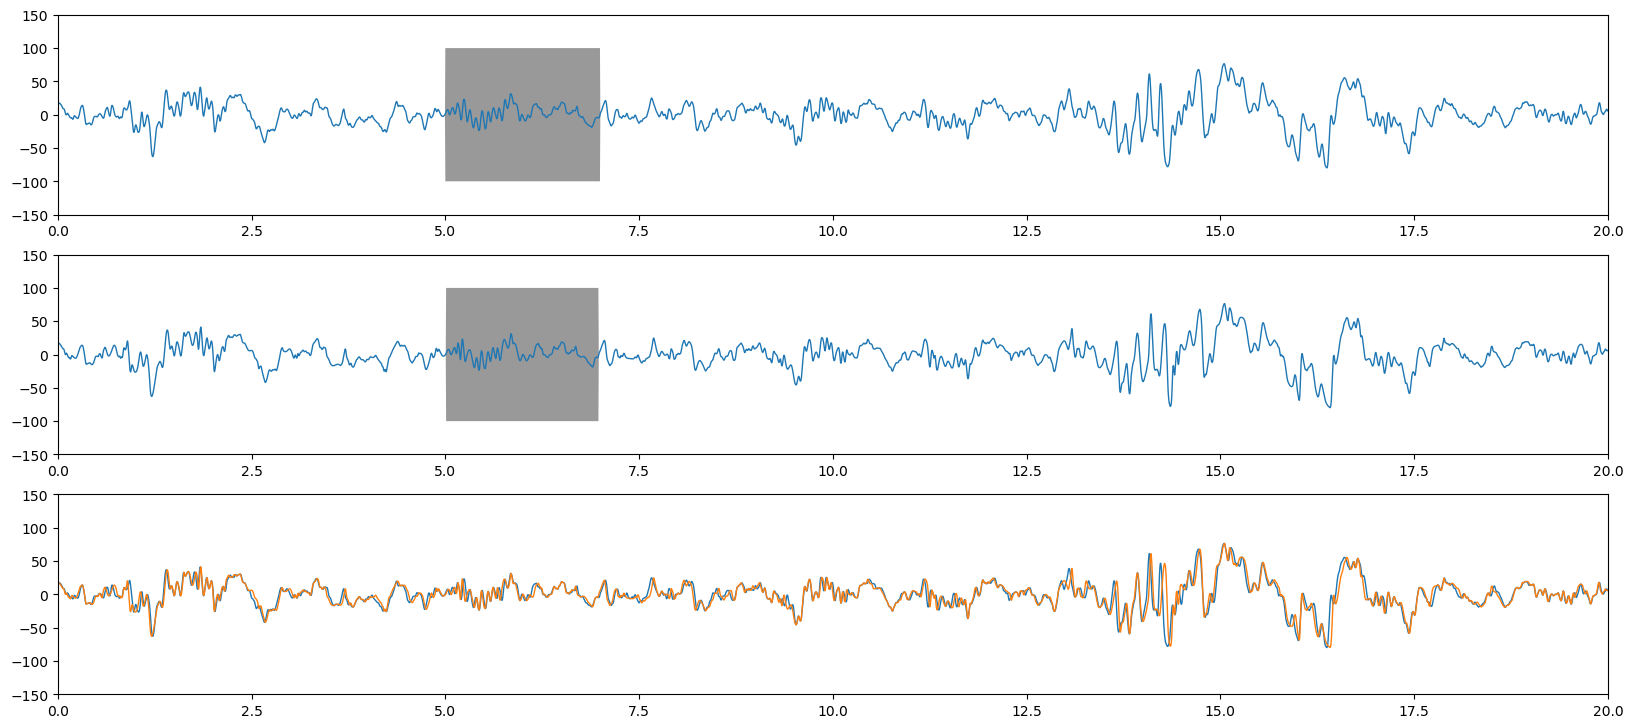

In [38]:
tf.reset_default_graph()

feat_ph = tf.placeholder(dtype=tf.float32, shape=[input_size])
label_ph = tf.placeholder(dtype=tf.int32, shape=[input_size])

new_feat, new_label = elastic_1d_deformation(feat_ph, label_ph, alpha=40, sigma=10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    elastic_feat, elastic_label = sess.run([new_feat, new_label], feed_dict={feat_ph: signal[start_sample:end_sample], label_ph: label_dummy})
    
print(elastic_feat.shape, elastic_feat.dtype)
print(elastic_label.shape, elastic_label.dtype)

fig, ax = plt.subplots(3, 1, figsize=(20, 9), dpi=100)
time_axis = np.arange(input_size) / fs
ax[0].plot(time_axis, signal[start_sample:end_sample], linewidth=1)
ax[0].fill_between(time_axis, -100*label_dummy, 100*label_dummy, facecolor='k', alpha=0.4)
ax[0].set_ylim([-150, 150])
ax[0].set_xlim([0, segment_size])

ax[1].plot(time_axis, elastic_feat, linewidth=1)
ax[1].fill_between(time_axis, -100*elastic_label, 100*elastic_label, facecolor='k', alpha=0.4)
ax[1].set_ylim([-150, 150])
ax[1].set_xlim([0, segment_size])

ax[2].plot(time_axis, signal[start_sample:end_sample], linewidth=1)
ax[2].plot(time_axis, elastic_feat, linewidth=1)
ax[2].set_ylim([-150, 150])
ax[2].set_xlim([0, segment_size])

plt.show()